In [104]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using AtomsBuilder
using ComponentArrays
using DFTK
using ForwardDiff
using LinearAlgebra
using Plots
using PseudoPotentialData
using Random
using Unitful
using UnitfulAtomic

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


# Defining a custom XC functional in DftFunctionals.jl

It is easy to define a new exchange-correlation functional and use it with DFTK.
Defining an energy expression is sufficient: We will use ForwardDiff
to automatically compute exchange-correlation energy derivatives of 
- first-order: the XC potential for the SCF solver, and
- second-order the XC kernel, used for DFPT.

(*Technical remark: Currently this functionality is limited to GGA-type functionals.*)

In [51]:
using DftFunctionals

"""
The BEEF ensemble is described by a Gaussian distribution
    in parameters θ ∼ N(θ_bf, LLᵀ)
    or equivalently: θ = θ_bf + L * α
    where α is standard normal.

From the paper:
    `Bayesian Error Estimation in Density-Functional Theory` (2005)
    J. J. Mortensen, K. Kaasbjerg, S. L. Frederiksen, J. K. Nørskov,
    J. P. Sethna, and K. W. Jacobsen
    DOI: https://doi.org/10.1103/PhysRevLett.95.216401
"""
function params_beef_2005()
    θ_bf = [1.0008, 0.1926, 1.8962]  # After Eq (4)
    L = [
        0.066 0.055 -0.034 
       -0.812 0.206  0.007 
        1.996 0.082  0.004
    ]  # Eq (5)
    (; θ_bf, L)
end

struct BeefExchange{T} <: Functional{:gga,:x} where {T}
    θ::T
    identifier::Symbol
end
BeefExchange(θ) = BeefExchange(θ, :gga_x_beef_custom)

DftFunctionals.parameters(beefx::BeefExchange) = beefx.θ
DftFunctionals.identifier(beefx::BeefExchange) = beefx.identifier

function DftFunctionals.change_parameters(beefx::BeefExchange, parameters::AbstractArray;
    keep_identifier=false)
    if keep_identifier
        BeefExchange(parameters, beefx.identifier)
    else
        BeefExchange(parameters)
    end
end

function f_x_beef(s, θ)
    sum(enumerate(θ)) do (i, θi)
        θi * (s / (one(s) + s))^(2i - 2)  # (3)
    end
end

function DftFunctionals.energy(beefx::BeefExchange, ρ::T, σ::U) where {T<:Number,U<:Number}
    TT = DftFunctionals.arithmetic_type(beefx, T, U)

    # s is the dimensionless electron density gradient
    # s = sqrt(σ) / (2kF * ρ)  # Above eq (2)
    s = sqrt(σ) / (ρ^(4 / 3) * 2cbrt(3π^2))
    
    θ = beefx.θ

    res = DftFunctionals.energy(LdaExchange(), ρ) * f_x_beef(s, θ)
    TT(res)
end

make_beef(θ) = [DftFunctional(Val(:gga_c_pbe)), BeefExchange(θ)]

make_beef (generic function with 1 method)

Let's visualize the exchange-enhancement factor ensemble (as Fig 1. in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.216401)

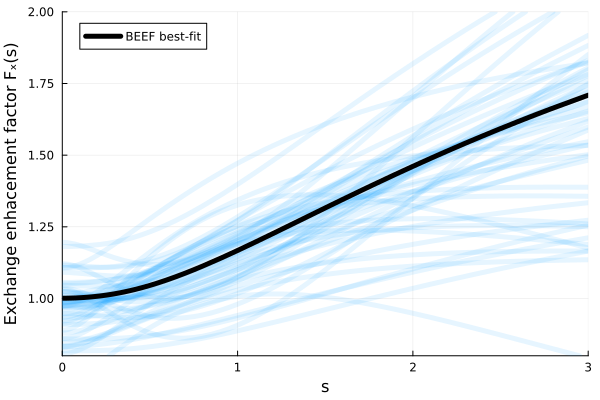

In [52]:
let 
    params = params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 50
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for δθ in eachcol(δθ_ensemble)
        plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=1, linealpha=0.1, lw=5)
    end
    plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf), label="BEEF best-fit",
    linewidth=5, color=:black)
    fig_fx_ensemble
end

## Using the custom XC functional in DFTK

In [86]:
params = params_beef_2005()
functionals = make_beef(params.θ_bf)

2-element Vector{Functional{:gga}}:
 gga_c_pbe
 gga_x_beef_custom

In [110]:
a0_beef = 10.328164895118894  # From a prior geometry relaxation
a0 = a0_beef
system = bulk(:Si; a=a0_beef * u"bohr")

FlexibleSystem(Si₂, periodicity = TTT):
    cell_vectors      : [       0  5.16408  5.16408;
                          5.16408        0  5.16408;
                          5.16408  5.16408        0]u"a₀"

    Atom(Si, [       0,        0,        0]u"a₀")
    Atom(Si, [ 2.58204,  2.58204,  2.58204]u"a₀")


In [ ]:
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
(; lattice, atoms, positions) = DFTK.parse_system(system, pseudopotentials)
model = model_DFT(lattice, atoms, positions; functionals, temperature)

Ecut = recommended_cutoff(model).Ecut
kgrid = (8, 8, 8)
basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 1
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([8, 8, 8])
    num.   red. kpoints  : 512
    num. irred. kpoints  : 29

    Discretized Model(gga_c_pbe+gga_x_beef_custom, 3D):
        lattice (in Bohr)    : [0         , 5.16408   , 5.16408   ]
                               [5.16408   , 0         , 5.16408   ]
                               [5.16408   , 5.16408   , 0         ]
        unit cell volume     : 275.43 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.

In [108]:
scfres = self_consistent_field(basis; tol=1e-8)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450568007533                   -0.96    4.5    661ms
  2   -8.452296770854       -2.76       -1.48    1.0    443ms
  3   -8.452534123311       -3.62       -2.84    1.7    545ms
  4   -8.452557930273       -4.62       -3.34    3.2    1.28s
  5   -8.452557970973       -7.39       -3.71    1.4    424ms
  6   -8.452557993935       -7.64       -4.33    2.4    482ms
  7   -8.452557995388       -8.84       -4.73    2.1    495ms
  8   -8.452557995464      -10.12       -5.19    1.6    476ms
  9   -8.452557995484      -10.69       -5.74    1.7    444ms
 10   -8.452557995486      -11.94       -5.99    2.1    464ms
 11   -8.452557995485   +  -12.27       -6.70    1.2    1.11s
 12   -8.452557995485   +  -12.97       -7.14    2.2    492ms
 13   -8.452557995485      -13.29       -7.82    1.4    426ms
 14   -8.452557995485      -13.75       -7.99    2.2    516ms
 15   -8.

(ham = Hamiltonian(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([8, 8, 8])), HamiltonianBlock[DFTK.DftHamiltonianBlock(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([8, 8, 8])), KPoint([     0,      0,      0], spin = 1, num. G vectors =   965), Any[DFTK.FourierMultiplication{Float64, Vector{Float64}}(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([8, 8, 8])), KPoint([     0,      0,      0], spin = 1, num. G vectors =   965), [0.0, 0.5551427464074018, 2.220570985629607, 4.996284717666616, 8.882283942518429, 13.878568660185042, 13.878568660185042, 8.882283942518429, 4.996284717666616, 2.220570985629607  …  2.0355234034938063, 4.4411419712592135, 7.957046031839424, 12.583235585234439, 16.284187227950454, 10.917807346012234, 6.661712956888822, 3.515904060580

In [109]:
compute_stresses_cart(scfres)

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  9.76187e-7    0.0          0.0
 -5.64689e-22   9.76187e-7   0.0
  0.0          -5.64689e-22  9.76187e-7

## Computing XC parameter sensitivities by AD-DFPT

In [114]:
function setup_basis(θ, a, make_functionals, Ecut, kgrid)
    T = promote_type(eltype(θ), eltype(a))
    lattice_new = (a / a0) * lattice
    model_new = model_DFT(T.(lattice_new), atoms, positions;
                          functionals=make_functionals(θ), symmetries)
    basis_new = PlaneWaveBasis(model_new; Ecut, kgrid)
end

setup_basis (generic function with 1 method)

In [115]:
function hellmann_feynman_observables(θ, a, make_functionals; Ecut, kgrid, tol)
    # 1. Setup
    basis = setup_basis(θ, a, make_functionals, Ecut, kgrid)

    # 2. Solve
    scfres = self_consistent_field(basis; tol)

    # 3. Postprocess
    ForwardDiff.gradient(ComponentVector(; θ, a)) do x
        basis_new = setup_basis(x.θ, x.a, make_functionals, Ecut, kgrid)
        ρ = compute_density(basis_new, scfres.ψ, scfres.occupation)
        (; energies) = DFTK.energy(basis_new, scfres.ψ, scfres.occupation;
                                ρ, scfres.eigenvalues, scfres.εF)
        energies.total
    end
end

hellmann_feynman_observables (generic function with 2 methods)

In [116]:
hellmann_feynman_observables(params.θ_bf, a0, make_beef; Ecut, kgrid, tol=1e-6)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450476476963                   -0.96    4.2    514ms
  2   -8.452395430190       -2.72       -1.81    1.0    339ms
  3   -8.452550366546       -3.81       -2.90    2.1    415ms
  4   -8.452557915513       -5.12       -3.46    2.9    504ms
  5   -8.452558006619       -7.04       -4.16    1.6    382ms
  6   -8.452558011336       -8.33       -5.22    2.0    414ms
  7   -8.452558011537       -9.70       -6.19    3.0    1.22s


ComponentVector{Float64}(θ = [-2.614264409712475, -0.20714830055517597, -0.022445196290470797], a = 7.829294190636604e-5)

In [117]:
grad = ForwardDiff.derivative(
    a -> hellmann_feynman_observables(params.θ_bf, a, make_beef; Ecut, kgrid, tol=1e-6),
    a0
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450474175692                   -0.96    4.3    523ms
  2   -8.452392768643       -2.72       -1.81    1.0    345ms
  3   -8.452547425730       -3.81       -2.92    2.1    410ms
  4   -8.452557913544       -4.98       -3.38    3.0    523ms
  5   -8.452558004606       -7.04       -3.92    1.4    1.18s
  6   -8.452558010829       -8.21       -4.93    1.3    322ms
  7   -8.452558011522       -9.16       -5.21    2.9    550ms
  8   -8.452558011537      -10.83       -6.14    1.1    330ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      56.7   1.32s  Non-interacting
   1        0       1       -0.86     40.3   1.90s  
   2        0       2       -2.63     34.3   977ms  
   3        0       3       -3.90     18.5   716ms  
 

ComponentVector{Float64}(θ = [0.15020957969687032, -0.01962092269509408, -0.0056184771089965516], a = 0.07012566908506343)

In [120]:
∂a_∂θ = grad.a \ grad.θ  # Implicit derivative of relaxed lattice constant w.r.t. θ

3-element Vector{Float64}:
  2.1420056543726376
 -0.27979658449024736
 -0.08012012123807702

## Predictive XC uncertainty in the lattice constant

We compute a linearized Gaussian pushfoward uncertainty
$$
\mathcal{N}(\theta_0, LL^\top) \to \mathcal{N}(a^\star(\theta_0), J LL^\top J^\top)
$$
where $J = \frac{\partial a^\star}{\partial\theta}\lvert_{\theta_0}$ is the implicit derivative of the lattice constant as a function of the XC parameters, evaluated at mean parameters $\theta_0$.

In [121]:
lattice_constant_uncertainty = norm(params.L'∂a_∂θ)

0.22814045152810836

In [124]:
a0_exp = austrip(5.422u"angstrom")

10.246095047720924

In [127]:
println("True error:           ", a0 - a0_exp)
println("Uncertainty estimate: ", lattice_constant_uncertainty)

True error:           0.0820698473979693
Uncertainty estimate: 0.22814045152810836


In [ ]:
# TODO: For a comparison example of this approach to ensemble propagation (Monte-Carlo),
#       see Figure 7 in https://arxiv.org/abs/2509.07785